In [1]:
import sys
sys.path.append('../utils/')

from utils import *
from TableMapper import TableMapper

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
query, schema = get_spider_schema_table_files()
tableMapper = TableMapper(query, schema)

In [3]:
res = []
count1 = 0
count2 = 0
for i in tqdm(list(set(schema.schema_id.values))):
    s, t = tableMapper.get_filtered_schema(i)
    count_match, count_all = tableMapper.get_exact_match_accuracy(s, t)

    count1 += count_match
    count2 += count_all

    if(count1 == 0):
        print(i)

    res.append([i, count_match/count_all, len(s), len(t)])

  0%|          | 0/166 [00:00<?, ?it/s]

In [4]:
test_schema = 'yelp'
s, t = tableMapper.get_filtered_schema(test_schema)
count_match, count_all = tableMapper.get_exact_match_accuracy(s, t, 0)
print(count_match / count_all)
# print(tableMapper.get_exact_match_accuracy(t, s, verbosity=1))

0.17117117117117117


0.6576313752952259
0.5712958182756841


,schema_id,score,num_tables,num_queries
0,restaurants,0.008000,3,125
1,scholar,0.015817,10,569
2,academic,0.165746,15,181
3,icfp_1,0.166667,4,66
4,yelp,0.171171,7,111
5,tracking_orders,0.183333,7,60
6,products_gen_characteristics,0.197674,6,86
7,baseball_1,0.243902,26,82
8,imdb,0.247706,16,109
9,train_station,0.260870,3,23


<AxesSubplot:>

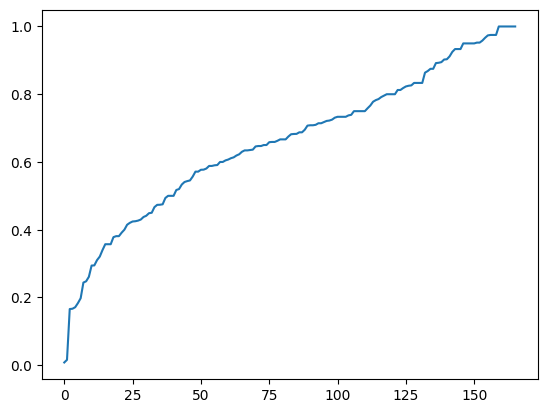

In [5]:
score_df = pd.DataFrame(res, columns = ['schema_id', 'score', 'num_tables', 'num_queries']).sort_values(by = 'score').reset_index(drop = True)
print(score_df.score.mean())
print(count1 / count2)
display(score_df.head(10))
score_df.score.plot()

In [6]:
print(count1)
print(count2)

# 5194
# 9685

# 5223
# 9685

5533
9685


In [7]:
tableMapper.get_table_names_tql(s, 'How many reviews are less than 1')

['review']